# Video processing with object detection using batch inference

This tutorial uses Ray and Anyscale for distributed data processing, PyTorch with a pre-trained Faster R-CNN model for object detection, and several other Python libraries for image and video handling. It shows how to:

* Load a video from S3.
* Split the video into individual frames.
* Apply an object detection model to detect masks.
* Draw bounding boxes and labels on each frame.
* Generate a new video from the processed frames.

This approach is very similar to the evaluation-focused pipeline in the previous notebook, in which it leverages batch inference with Ray Data, but unlike the previous notebook, this tutorial is purely inference—without computing metrics like mAP or IoU. Instead, it represents a real-world video analytics workflow, suitable for deployment in production environments.

Here is the architecture diagram illustrates a distributed video processing pipeline using Ray Data batch inference on Anyscale for mask detection. 

![Pipeline Overview](https://face-masks-data.s3.us-east-2.amazonaws.com/tutorial-diagrams/batch_inference_metrics_calculation.png)


<div class="alert alert-block alert-warning">
  <b>Anyscale-Specific Configuration</b>
  
  <p>Note: This tutorial is optimized for the Anyscale platform. When running on open source Ray, additional configuration is required. For example, you’ll need to manually:</p>
  
  <ul>
    <li>
      <b>Configure your Ray Cluster:</b> Set up your multi-node environment (including head and worker nodes) and manage resource allocation (e.g., autoscaling, GPU/CPU assignments) without the Anyscale automation. See the Ray Cluster Setup documentation for details: <a href="https://docs.ray.io/en/latest/cluster/getting-started.html">https://docs.ray.io/en/latest/cluster/getting-started.html</a>.
    </li>
    <li>
      <b>Manage Dependencies:</b> Install and manage dependencies on each node since you won’t have Anyscale’s Docker-based dependency management. Refer to the Ray Installation Guide for instructions on installing and updating Ray in your environment: <a href="https://docs.ray.io/en/latest/ray-core/handling-dependencies.html">https://docs.ray.io/en/latest/ray-core/handling-dependencies.html</a>.
    </li>
    <li>
      <b>Set Up Storage:</b> Configure your own distributed or shared storage system (instead of relying on Anyscale’s integrated cluster storage). Check out the Ray Cluster Configuration guide for suggestions on setting up shared storage solutions: <a href="https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html">https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html</a>.
    </li>
  </ul>

</div>


## Why use Ray and Anyscale for batch inference

Batch inference with Ray and Anyscale is a more efficient way to handle large-scale inference tasks compared to the traditional method of serving and processing image requests one by one using APIs or endpoints. Instead of handling each request individually, batch inference processes multiple inputs simultaneously, leading to significant performance improvements. The key benefits include:

* **Higher throughput** – Processing multiple images at once reduces the overhead of repeatedly loading the model and managing individual inference requests.
* **Better resource utilization** – Ray uses GPUs and other hardware accelerators more efficiently when running inference in batches rather than performing single-image inferences, which can lead to underutilization.
* **Lower latency for bulk processing** – While batch inference may introduce slight delays for individual requests, it significantly reduces the overall time required to process large datasets, making it ideal for offline or faster processing of videos.
* **Scalability** – Batch inference with Ray allows distributed processing across multiple nodes, enabling efficient scaling for high-volume workloads.
* **Automatic resource shutdown and cost efficiency** – Instead of keeping inference servers running continuously, once batch inference completes, Ray automatically shuts down idle resources, preventing unnecessary compute usage. You can also schedule batch processing during off-peak hours or using `spot instances`, leading to significant cost savings on compute resources.





## Import libraries and define label mappings
The first block of code imports all necessary libraries and sets up mappings for our classes (e.g., "with_mask", "without_mask", etc.) and their corresponding colors for visualization.

In [1]:
import ray
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import torch
from torchvision import models
import os
from smart_open import open as smart_open


CLASS_TO_LABEL = {
    "background": 0,
    "with_mask": 1,
    "without_mask": 2,
    "mask_weared_incorrect": 3
}
LABEL_TO_CLASS = {v: k for k, v in CLASS_TO_LABEL.items()}
LABEL_COLORS = {
    "with_mask": "green",
    "without_mask": "red",
    "mask_weared_incorrect": "yellow"
}





## Load and split video into frames
Load the video file from an S3 bucket using the Ray Data API. Then convert it into individual frames. Each frame is stored along with its frame number.

The Dataset should have two columns `frame` and `frame_index`.


Note that `ray.data.read_videos` can also process directories containing multiple videos. In this case, consider setting the `include_paths` parameter to `True` to store file paths in the path column. This setting helps track which video each frame originated from.

For more details, see: https://docs.ray.io/en/latest/data/api/doc/ray.data.read_videos.html#ray.data.read_videos

In [2]:

ds_frames = ray.data.read_videos("s3://face-masks-data/videos/video1.mp4")
ds_frames.schema()

2025-02-25 23:58:14,840	INFO worker.py:1654 -- Connecting to existing Ray cluster at address: 10.0.23.22:6379...
2025-02-25 23:58:14,850	INFO worker.py:1832 -- Connected to Ray cluster. View the dashboard at https://session-3d9pcv3n1i9c9stdktc2qjksgx.i.anyscaleuserdata.com 
2025-02-25 23:58:14,889	INFO packaging.py:366 -- Pushing file package 'gcs://_ray_pkg_eb4bdae774f7a00803f0d490a3f6e844f1fd9a66.zip' (16.34MiB) to Ray cluster...
2025-02-25 23:58:14,964	INFO packaging.py:379 -- Successfully pushed file package 'gcs://_ray_pkg_eb4bdae774f7a00803f0d490a3f6e844f1fd9a66.zip'.
2025-02-25 23:58:16,411	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_23-57-11_533107_3632/logs/ray-data
2025-02-25 23:58:16,412	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

(autoscaler +14s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +14s) [autoscaler] [4CPU-8GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +14s) [autoscaler] Launched 1 instances.


Column       Type
------       ----
frame        numpy.ndarray(shape=(1080, 1920, 3), dtype=uint8)
frame_index  int64

### Visualize some frames

You can see there are in total 383 frames in the video. 


2025-02-25 23:59:14,616	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_23-57-11_533107_3632/logs/ray-data
2025-02-25 23:59:14,617	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

Total number of frames: 308


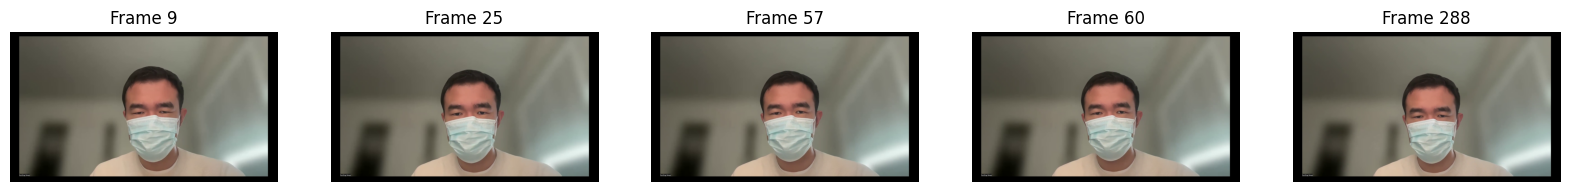

In [3]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame
df = ds_frames.to_pandas()

# Print the total number of frames
print("Total number of frames:", len(df))

# Randomly sample 5 frames
sampled_frames = df.sample(n=5, random_state=42).sort_values(by="frame_index")

# Display sampled frames
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, (idx, row) in enumerate(sampled_frames.iterrows()):
    frame_data = row["frame"]
    axes[i].imshow(frame_data)
    axes[i].axis("off")
    axes[i].set_title(f"Frame {row['frame_index']}")

plt.show()

## Load the object detection model
Next, create a class that loads a pre-trained Faster R-CNN model from AWS S3 to the cluster storage and applies it to a batch of images. 


Define the `BatchObjectDetectionModel` class to encapsulate the detection logic, which you can later use with the `map_batches` function in Ray Data.

Ray Data allows for two approaches when applying transformations like `map` or `map_batches`:

* **Functions**: These use stateless Ray tasks, which are ideal for simple operations that don’t require loading heavyweight models.
* **Classes**: These use stateful Ray actors, making them well-suited for more complex tasks involving heavyweight models—**exactly what you need in this case**.


In [4]:

# Paths.
remote_model_path = "s3://face-masks-data/finetuned-models/fasterrcnn_model_mask_detection.pth"
cluster_model_path = "/mnt/cluster_storage/fasterrcnn_model_mask_detection.pth"

# Download model only once.
if not os.path.exists(cluster_model_path):
    with smart_open(remote_model_path, "rb") as s3_file:
        with open(cluster_model_path, "wb") as local_file:
            local_file.write(s3_file.read())

# Load the model (driver verifies it works).
loaded_model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(CLASS_TO_LABEL))
loaded_model.load_state_dict(torch.load(cluster_model_path, map_location="cpu"))
loaded_model.eval()


class BatchObjectDetectionModel:
    def __init__(self):
        self.model = loaded_model
        if torch.cuda.is_available():
            self.model = self.model.cuda()

    def __call__(self, batch: dict) -> dict:
        predictions = []
        for image_np in batch["frame"]:
            image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0
            if torch.cuda.is_available():
                image_tensor = image_tensor.cuda()
            with torch.no_grad():
                pred = self.model([image_tensor])[0]
            predictions.append({
                "boxes": pred["boxes"].detach().cpu().numpy(),
                "labels": pred["labels"].detach().cpu().numpy(),
                "scores": pred["scores"].detach().cpu().numpy()
            })
        batch["predictions"] = predictions
        return batch


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s] 


## Apply the object detection model

Apply the BatchObjectDetectionModel to each batch of frames using the Ray Data `map_batches` method. This step performs object detection on all frames in parallel.

### Understand key parameters
* **concurrency**: Defines the number of parallel workers processing batches. Increasing this value enables more workers to process data simultaneously, speeding up computation but requiring more system resources (CPU, memory, and GPUs).
* **batch_size**: Specifies how many frames each worker processes at a time. A larger batch size increases throughput but may require more GPU memory. Finding the optimal batch size depends on the available memory of your GPUs.
* **num_gpus**: Sets the number of GPUs each worker can use. In this case, you allocate 1 GPU to each worker, meaning the total number of GPUs used is `concurrency` * `num_gpus`.

### Adjust for performance:
* If your system has more GPUs, you can increase concurrency to use more parallel workers.
* If you have limited GPU memory, try reducing `batch_size` to avoid memory overflow.


For more informaiton, see: https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html

In [11]:
# Apply object detection model.
ds_predicted = ds_frames.map_batches(
    BatchObjectDetectionModel,
    concurrency=2,   # Specify 2 workers.
    batch_size=8,
    num_gpus=1 # Each worker uses 1 GPU. In total Ray Data uses 2 GPUs.
)

## Draw bounding boxes and labels on each frame
Next, define a function to draw bounding boxes and labels on the detected objects. This step uses the predictions from your model and the mappings you defined earlier.

In [14]:

# Draw bounding boxes and labels on each frame.
def draw_boxes(row):
    image_np = row["frame"]
    predictions = row["predictions"]
    boxes = predictions["boxes"]
    labels = predictions["labels"]
    scores = predictions["scores"]

    confidence_threshold = 0.5
    valid = scores > confidence_threshold
    boxes = boxes[valid]
    labels = labels[valid]
    scores = scores[valid]

    pil_image = Image.fromarray(image_np)
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.load_default()

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        class_name = LABEL_TO_CLASS.get(label, "unknown")
        color = LABEL_COLORS.get(class_name, "white")

        # Draw bounding box.
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)

        # Prepare text.
        text = f"{class_name} {score:.2f}"
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Draw text background.
        draw.rectangle(
            [x1, y1 - text_height - 2, x1 + text_width, y1],
            fill=color
        )

        # Draw text.
        text_color = "black" if color == "yellow" else "white"
        draw.text(
            (x1, y1 - text_height - 2),
            text,
            fill=text_color,
            font=font
        )

    return {
        "frame": np.array(pil_image),
        "frame_index": row["frame_index"]
    }




ds_visualized = ds_predicted.map(draw_boxes)

## Collect and sort processed frames
After processing, collect all frames and sort them by frame number to ensure the video plays in the correct order.

Note that Ray Data uses lazy execution with `map` and `map_batches` in the previous steps, meaning Ray Data performs no actions immediately. To force computation and execute the pipeline, use ds_visualized.take_all().


In [13]:

processed_frames = ds_visualized.take_all()
print("processed_frames", len(processed_frames))
sorted_frames = sorted(processed_frames, key=lambda x: x["frame_index"])

2025-02-26 00:04:35,880	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_23-57-11_533107_3632/logs/ray-data
2025-02-26 00:04:35,880	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[MapBatches(BatchObjectDetectionModel)] -> TaskPoolMapOperator[Map(draw_boxes)]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

- MapBatches(BatchObjectDetectionModel) 4: 0.00 row [00:00, ? row/s]

- Map(draw_boxes) 5: 0.00 row [00:00, ? row/s]

processed_frames 308


## Generate the output video
Finally, generate a new video from the processed frames using OpenCV. Generate a video in `webm` format and display it in this Jupyter notebook. 

You can also modify the code to generate MP4 or the other formats. They work well when you play locally, but some browsers (and the Jupyter Notebook interface, which relies on the browser's video capabilities) expect the MP4 file to have the "moov" atom (metadata) at the beginning of the file to enable streaming. In many cases, the `cv2.VideoWriter` might place this metadata at the end, which doesn't affect desktop players as much but can cause issues when embedding in a browser. Formats like `webm` are often more friendly for browser playback without requiring extra post-processing steps.


In [15]:
# Generate output video in WebM format.
output_video_path = "./saved_videos/output_video.webm"  # Save video to .webm format.
os.makedirs(os.path.dirname(output_video_path), exist_ok=True)  # Create directory if needed.

if sorted_frames:
    # Get video properties from the first frame.
    height, width, _ = sorted_frames[0]["frame"].shape

    # Initialize video writer with VP8 codec for WebM.
    fourcc = cv2.VideoWriter_fourcc(*"VP80")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, 30.0, (width, height))

    for frame in sorted_frames:
        # Convert RGB to BGR for OpenCV.
        bgr_frame = cv2.cvtColor(frame["frame"], cv2.COLOR_RGB2BGR)
        video_writer.write(bgr_frame)

    video_writer.release()
    print(f"Output video saved to: {output_video_path}")
else:
    print("No frames available for video creation.")


OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


Output video saved to: ./saved_videos/output_video.webm


## Inspect the output video

You can now visualize the video within the Jupyter Notebook using the following code. Alternatively, download the video locally to verify that the object detection model rendered every frame with masks.

The model performs well initially; however, as the person moves the pen in front of his face, its accuracy decreases, occasionally producing incorrect detection results.

This behavior is a common challenge in object detection, especially when the model lacks sufficient training data for such scenarios. To mitigate this issue, consider collecting additional data that specifically addresses it.

In [21]:
from IPython.core.display import display, HTML

video_path = "saved_videos/output_video.webm"

video_html = f"""
<video width="640" height="360" controls>
  <source src="{video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
"""

display(HTML(video_html))

/tmp/ipykernel_5194/2083308019.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


(autoscaler +11m14s) [autoscaler] Downscaling node i-0280b3b0271e7002b (node IP: 10.0.47.27) due to node idle termination.
(autoscaler +11m14s) [autoscaler] Downscaling node i-027c8172ce5ce12ff (node IP: 10.0.51.181) due to node idle termination.
(autoscaler +15m59s) [autoscaler] [1xT4:4CPU-16GB] Attempting to add 2 node(s) to the cluster (increasing from 0 to 2).
(autoscaler +15m59s) [autoscaler] Launched 2 instances.
(autoscaler +16m59s) [autoscaler] Cluster upscaled to {8 CPU, 2 GPU}.
(autoscaler +25m49s) [autoscaler] Downscaling node i-0b4305870845f35b0 (node IP: 10.0.27.63) due to node idle termination.
(autoscaler +25m49s) [autoscaler] Downscaling node i-081149cbb16649309 (node IP: 10.0.15.214) due to node idle termination.
(autoscaler +29m44s) [autoscaler] [1xT4:4CPU-16GB] Attempting to add 2 node(s) to the cluster (increasing from 0 to 2).
(autoscaler +29m44s) [autoscaler] Launched 2 instances.
(autoscaler +30m44s) [autoscaler] Cluster upscaled to {8 CPU, 2 GPU}.
(autoscaler +3